In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smoted-comparison/SMOTEd_NK/0_trn_lab
/kaggle/input/smoted-comparison/SMOTEd_NK/0_trn_img
/kaggle/input/smoted-comparison/Imb_CIFAR10/trn_lab_imb
/kaggle/input/smoted-comparison/Imb_CIFAR10/trn_img_imb
/kaggle/input/smoted-comparison/valid_label/3_valid_label
/kaggle/input/smoted-comparison/valid_label/0_valid_label
/kaggle/input/smoted-comparison/valid_label/4_valid_label
/kaggle/input/smoted-comparison/valid_label/1_valid_label
/kaggle/input/smoted-comparison/valid_label/2_valid_label
/kaggle/input/smoted-comparison/valid_data/2_valid_data
/kaggle/input/smoted-comparison/valid_data/4_valid_data
/kaggle/input/smoted-comparison/valid_data/3_valid_data
/kaggle/input/smoted-comparison/valid_data/1_valid_data
/kaggle/input/smoted-comparison/valid_data/0_valid_data


In [2]:
import torch, torchvision
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
# from sklearn.model_selection import train_test_split

# 載入自訂格式的資料集

## 方法一：自定義 customDataset

* 繼承 torch.utils.data 中的 Dataset 類別
* 實作 __init__()、 __get_item__()、 __len__() 三個方法

In [3]:
from torch.utils.data import Dataset
import PIL.Image as Image

# Method 1: define customDataset class, succeed from Dataset class
class customDataset(Dataset):
    def __init__(self, datapath, labelpath, transform=None):
        # --------------------------------------------
        # load file from paths, check dtype, reshape, transform, prepare array-like object for getitem method
        # --------------------------------------------
        
        dec_x = np.loadtxt(datapath)
        dec_y = np.loadtxt(labelpath)
        dec_y = dec_y.astype('long')
        dec_x = dec_x.reshape(dec_x.shape[0], 3, 32, 32) # channel-first image
        
        #PIL_x = Image.fromarray(dec_x)
        #PIL_x = Image.fromarray(np.uint8(dec_x), mode='RGB')
        #tensor_y = torch.tensor(dec_y,dtype=torch.long)
        
        self.transform = transform
        
        self.imgs = dec_x
        self.labs = dec_y       
        
    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Use index to get item from array-like object
        # 2. Preprocess the data (PIL.Image, torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        imgcf = self.imgs[index] # shape = (3, 32, 32), channel-first
        #print('the shape of np_imgcf: {}'.format(imgcf.shape)) # the shape of np_img: (3, 32, 32)
        imgcl = np.moveaxis(imgcf, 0, -1)  # change to channel-last
        #print('the shape of np_imgcl: {}'.format(imgcl.shape)) # the shape of np_img: (32, 32, 3)
        
        imgcl = (imgcl + 1) / 2 * 255 # denormalize to fit Image.fromarray()
        #print('the max of np_img: {}'.format(imgcl.max()))   # 255
        #print('the min of np_img: {}'.format(imgcl.min()))   # 0  
        img = Image.fromarray(np.uint8(imgcl), mode='RGB')
        #print('the size of img: {}'.format(img.size))      # (32, 32)
        
        
        lab = self.labs[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, lab
        
        
    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.imgs)


In [4]:
# Method 2: Use TensorDataset
'''
dec_x = np.loadtxt(datapath)
dec_y = np.loadtxt(labelpath)
dec_x = dec_x.reshape(dec_x.shape[0],1,28,28)
tensor_x = torch.Tensor(dec_x)
tensor_y = torch.tensor(dec_y,dtype=torch.long)
mnist = TensorDataset(tensor_x,tensor_y) 
'''

'\ndec_x = np.loadtxt(datapath)\ndec_y = np.loadtxt(labelpath)\ndec_x = dec_x.reshape(dec_x.shape[0],1,28,28)\ntensor_x = torch.Tensor(dec_x)\ntensor_y = torch.tensor(dec_y,dtype=torch.long)\nmnist = TensorDataset(tensor_x,tensor_y) \n'

# 訓練

In [5]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

# device: 是否使用GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameter: epochs, batch size, learning rate
epochs = 4
epoch_count = 0
bs = 128
lr = 0.0005

# Load Data and data processing
#If the image is torch Tensor, it is expected to have […, H, W] shape,


train_dpath = '/kaggle/input/smoted-comparison/Imb_CIFAR10/trn_img_imb'
train_lpath = '/kaggle/input/smoted-comparison/Imb_CIFAR10/trn_lab_imb'
#train_dpath = '/kaggle/input/imb-trn-cifar10/trn_img_imb/trn_img_imb'
#train_lpath = '/kaggle/input/imb-trn-cifar10/trn_lab_imb/trn_lab_imb'
valid_dpath = '/kaggle/input/smoted-comparison/valid_data/0_valid_data'
valid_lpath = '/kaggle/input/smoted-comparison/valid_label/0_valid_label'

transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),  
    #transforms.RandomHorizontalFlip(),  
    #transforms.RandomCrop(28, padding=4),  # MNIST=28 Cifar=32
    #transforms.RandomHorizontalFlip(),  # MNIST don't need to flip
    #transforms.RandomAffine(degrees = 30),
    #transforms.RandomPerspective(),
    #transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #R,G,B for mean and stderr
    #transforms.Normalize((0.1307,), (0.3081,)),
])

transform_test = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #transforms.Normalize((0.1307,), (0.3081,)),
])

trainset = customDataset(train_dpath, train_lpath, transform=transform_train)
validset = customDataset(valid_dpath,valid_lpath, transform=transform_test)
trainloader = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=2)
validloader = DataLoader(validset, batch_size=100, shuffle=True, num_workers=2)


# Class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Type of imgcl:<class 'numpy.ndarray'>
Shape of imgcl(32, 32, 3)
Max of img: 2.7537312507629395
min of img: -2.429065704345703


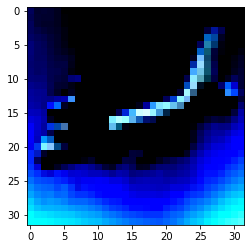

In [6]:
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    img = inputs[15]
    img = img.numpy()
    imgcl = np.moveaxis(img, 0, -1)
    print('Type of imgcl:{}'.format(type(imgcl)))
    print('Shape of imgcl{}'.format(imgcl.shape))
    print('Max of img: {}'.format(inputs.max()))
    print('min of img: {}'.format(inputs.min()))
    break 
plt.imshow(imgcl)

In [7]:
# Model instantiation
model = resnet18()

# [MNIST-only] change default in_channel from 3 to 1
#model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 

# change fc layer 
# the number of classes in our dataset is 10. default is 1000.
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optim = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) # mini-batch momentum-SGD
optim = optim.Adam(model.parameters(), lr=lr)

# decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optim, step_size=5, gamma=0.1)


# Train
#------------------------------------------------------------
# for loop to show how many epochs needed 
# # model.train()
# # initial values for losses, accuracy, so on
# # for loop to iterate data from train loader
# # # fetch and move data to device
# # # zero_grad optimizer
# # # forward pass and backward propagation, and then optimize
# # # print loss and accuracy every batch
# # after one epoch, use test data to check accuracy
# # with torch.no_grad()
# # # initial values for accuracy and so on
# # # for loop to iterate data from test loader
# # # # model.eval()
# # # # fetch and move data to device
# # # # forward pass
# # # # get the max from output
# # # # record correct and total
# # # calculate and print accuracy
# # # save result
# # # update best accuracy
#---------------------------------------------------------------
# initial value for best test accuracy
best_acc = 0.10
train_loss = []
test_accuracy = []
print("Start Training, Resnet-18!")
 

# for loop to show many epochs needed
for epoch in range(epoch_count, epochs):
    # print('\nEpoch: %d' % (epoch + 1)) # %-string
    print('\nEpoch: {0}'.format(epoch + 1))   # {[index]:[width][.precision][type]}
    model.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        # Preparing data
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optim.zero_grad()

        # forward + backward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optim.step()

        # print loss and accuracy every batch
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        #total += labels.size(0)
        #correct += predicted.eq(labels.data).cpu().sum()
        labels = labels.cpu().numpy()
        predicted = predicted.cpu().numpy()
        print('[epoch: {0}, iter: {1}] Loss: {2:.3f} | Acc: {3:.3%}'.format(
            epoch + 1, 
            i + 1 + epoch * length, 
            sum_loss / (i + 1), 
            metrics.f1_score(labels, predicted, average='macro'),))
        #f2.write('%03d  %05d |Loss: %.03f | Acc: %.3f%% '
              #% (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))
        #f2.write('\n')
        #f2.flush()

    # test accuracy after every epoch
    print("Waiting Test!")
    with torch.no_grad():
        #correct = 0
        #total = 0
        for data in validloader:
            model.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            #total += labels.size(0)
            #correct += (predicted == labels).sum()
            labels = labels.cpu().numpy()
            predicted = predicted.cpu().numpy()
            f1 = metrics.f1_score(labels, predicted, average='macro')
       
        print('F1 Score: {:.3%}'.format(f1))
        acc = f1
        acc = acc.item()
        test_accuracy.append(acc)
        
        
        #torch.save(model.state_dict(), '%s/net_%03d.pth' % (args.outf, epoch + 1))
        
        #f.write("EPOCH=%03d,Accuracy= %.3f%%" % (epoch + 1, acc))
        #f.write('\n')
        #f.flush()
        
        if acc > best_acc:
            #f3 = open("best_acc.txt", "w")
            #f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, acc))
            #f3.close()
            best_acc = acc
            print('Saving model......')
            torch.save(model.state_dict(), '/kaggle/working/bst_model.pth'.format(epoch + 1))
            

torch.save(model.state_dict(), '/kaggle/working/final_model.pth')
print('Training Finished, TotalEPOCH={}, best accuracy is: {:.3%}'.format(epochs, best_acc))


Start Training, Resnet-18!

Epoch: 1
[epoch: 1, iter: 1] Loss: 2.427 | Acc: 8.932%
[epoch: 1, iter: 2] Loss: 2.297 | Acc: 10.401%
[epoch: 1, iter: 3] Loss: 2.072 | Acc: 20.546%
[epoch: 1, iter: 4] Loss: 1.949 | Acc: 20.416%
[epoch: 1, iter: 5] Loss: 1.845 | Acc: 18.328%
[epoch: 1, iter: 6] Loss: 1.805 | Acc: 15.918%
[epoch: 1, iter: 7] Loss: 1.752 | Acc: 21.656%
[epoch: 1, iter: 8] Loss: 1.728 | Acc: 17.321%
[epoch: 1, iter: 9] Loss: 1.690 | Acc: 24.583%
[epoch: 1, iter: 10] Loss: 1.665 | Acc: 17.621%
[epoch: 1, iter: 11] Loss: 1.633 | Acc: 27.539%
[epoch: 1, iter: 12] Loss: 1.614 | Acc: 21.301%
[epoch: 1, iter: 13] Loss: 1.604 | Acc: 15.179%
[epoch: 1, iter: 14] Loss: 1.585 | Acc: 28.208%
[epoch: 1, iter: 15] Loss: 1.583 | Acc: 22.763%
[epoch: 1, iter: 16] Loss: 1.569 | Acc: 25.852%
[epoch: 1, iter: 17] Loss: 1.539 | Acc: 30.296%
[epoch: 1, iter: 18] Loss: 1.511 | Acc: 31.840%
[epoch: 1, iter: 19] Loss: 1.504 | Acc: 22.069%
[epoch: 1, iter: 20] Loss: 1.494 | Acc: 22.489%
[epoch: 1, it

In [8]:
test_accuracy

[0.35977824806772174,
 0.3407192379355683,
 0.3555461590770146,
 0.46246800088232326]

# 繪圖

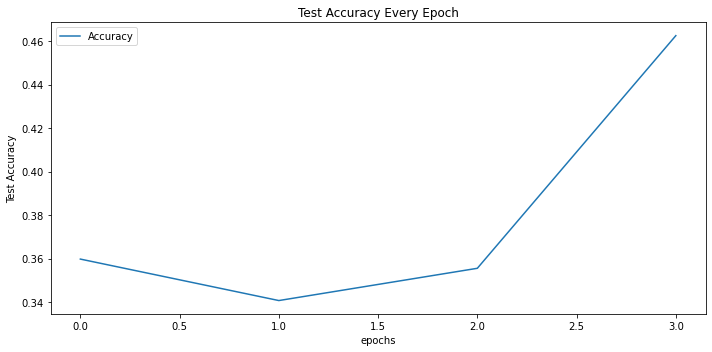

In [9]:
# Drawing

import matplotlib.pyplot as plt
%matplotlib inline 

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.figure(figsize=(10,5))
plt.title("Test Accuracy Every Epoch")
plt.plot(test_accuracy,label="Accuracy")
plt.xlabel("epochs")
plt.ylabel("Test Accuracy")
plt.legend()
plt.savefig('Accuracy.png')
plt.show()

In [10]:
np.savetxt('results.txt', np.array(test_accuracy))

In [11]:
avg = sum(test_accuracy)/len(test_accuracy)
print(avg)

0.37962791149065694
